# Overround Revenue Analysis - Multi-Probability Scenarios

Analysis of betting house revenue across multiple overround scenarios (10% to 90%) using three different probability sources:

1. **Logistic Probability (Best Case)**: Our trained prediction model
2. **Market Probability (Intermediate)**: Betting market implied probabilities
3. **Uniform Probability (Worst Case)**: No information scenario (1/n)

This notebook compares actual revenue against expected revenue under each information scenario to understand the value of predictive information.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Oscar model trainer module
from oscar_model_trainer import (
    get_predictions,
    calculate_bettors_with_elasticity,
    calculate_betting_house_revenue,
    calculate_expected_revenue
)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load Predictions from Trained Model

Load the last 5 years of predictions from the logistic regression model.


In [2]:
# Load predictions from the trained model
print("Training logistic regression model and generating predictions...")
predictions = get_predictions(years_back=5)

# Merge with market probabilities
print("\nMerging with market probabilities...")
market_df = pd.read_csv('market_probabilities.csv')
predictions = predictions.merge(
    market_df[['Film', 'market_probability']], 
    on=['Film'], 
    how='left'
)

# make sure the market_probability is a probability
predictions['market_probability'] = predictions.groupby('Year')['market_probability'].transform(
    lambda x: x / x.sum()
)

# Calculate uniform probability (1/n for each year - worst case scenario)
print("Calculating uniform probabilities...")
predictions['uniform_probability'] = predictions.groupby('Year')['Film'].transform(
    lambda x: 1 / len(x)
)

# Calculate fair odds for each probability model
print("Calculating fair odds for each probability model...")
predictions['fair_odds_logistic'] = 1 / predictions['Logistic_Probability']
predictions['fair_odds_market'] = 1 / predictions['market_probability']
predictions['fair_odds_uniform'] = 1 / predictions['uniform_probability']

print(f"\nPredictions loaded successfully!")
print(f"Shape: {predictions.shape}")
print(f"Years covered: {sorted(predictions['Year'].unique())}")
print(f"\nColumns available:")
print(list(predictions.columns))


Training logistic regression model and generating predictions...



Merging with market probabilities...
Calculating uniform probabilities...
Calculating fair odds for each probability model...

Predictions loaded successfully!
Shape: (47, 16)
Years covered: [np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]

Columns available:
['Year', 'Film', 'Actual_Winner', 'Logistic_Probability', 'Logistic_Predicted_Winner', 'Training_Size', 'fair_odds', 'implied_probability', 'belief_mean', 'belief_std', 'prop_active_bettors', 'market_probability', 'uniform_probability', 'fair_odds_logistic', 'fair_odds_market', 'fair_odds_uniform']


In [3]:
# Display sample predictions with all three probability sources
print("Sample predictions with all probability sources:")
print("\nProbability Sources:")
print("  - Logistic_Probability: Model prediction (best case - we have predictive model)")
print("  - market_probability: Betting market odds (intermediate - market information)")
print("  - uniform_probability: 1/n (worst case - no information)")
predictions[['Year', 'Film', 'Actual_Winner', 'Logistic_Probability', 
             'market_probability', 'uniform_probability', 
             'fair_odds_logistic', 'fair_odds_market', 'fair_odds_uniform', 'prop_active_bettors']]


Sample predictions with all probability sources:

Probability Sources:
  - Logistic_Probability: Model prediction (best case - we have predictive model)
  - market_probability: Betting market odds (intermediate - market information)
  - uniform_probability: 1/n (worst case - no information)


,Year,Film,Actual_Winner,Logistic_Probability,market_probability,uniform_probability,fair_odds_logistic,fair_odds_market,fair_odds_uniform,prop_active_bettors
0,2020.0,Nomadland,1,0.227612,0.215319,0.166667,4.393436,4.644267,6.0,0.100712
1,2020.0,The Father,0,0.183470,0.107660,0.166667,5.450491,9.288464,6.0,0.125127
2,2020.0,Mank,0,0.144525,0.153800,0.166667,6.919223,6.501964,6.0,0.185148
3,2020.0,Minari,0,0.161001,0.179433,0.166667,6.211137,5.573112,6.0,0.170905
4,2020.0,Promising Young Woman,0,0.103640,0.153800,0.166667,9.648739,6.501964,6.0,0.267548
5,2020.0,The Trial of the Chicago 7,0,0.179752,0.189988,0.166667,5.563235,5.263492,6.0,0.150560
6,2021.0,King Richard,0,0.116670,0.100471,0.090909,8.571176,9.953090,11.0,0.036000
7,2021.0,The Power of the Dog,0,0.085221,0.140660,0.090909,11.734222,7.109361,11.0,0.067000
8,2021.0,Nightmare Alley,0,0.071591,0.055524,0.090909,13.968147,18.010192,11.0,0.105000
9,2021.0,West Side Story,0,0.064999,0.111047,0.090909,15.384800,9.005181,11.0,0.130000


## 2. Configure Overround Scenarios

Test overrounds from 10% to 90% with 10% increments.

Using elasticity of -0.7: as overround increases, number of bettors decreases.


In [4]:
# Configuration
BASE_BETTORS = 1000  # Base number of bettors at 0% overround
BET_AMOUNT = 1      # Amount each bettor bets
ELASTICITY = -1    # Price elasticity of demand

# Generate overround scenarios from 0.1 to 0.9 (10% to 90%)
overrounds = np.arange(0.1, 1.0, 0.05)

# Calculate number of bettors for each overround
overround_scenarios = []
for overround in overrounds:
    bettors = calculate_bettors_with_elasticity(BASE_BETTORS, overround, ELASTICITY)
    label = f"{int(overround*100)}% Overround"
    overround_scenarios.append((overround, bettors, label))

# Display scenarios
print("Overround Scenarios:")
print("-" * 50)
print(f"{'Overround':<15} {'Bettors':<15} {'Label'}")
print("-" * 50)
for overround, bettors, label in overround_scenarios:
    print(f"{overround:.1%} {bettors:<15} {label}")


Overround Scenarios:
--------------------------------------------------
Overround       Bettors         Label
--------------------------------------------------
10.0% 900             10% Overround
15.0% 850             15% Overround
20.0% 799             20% Overround
25.0% 750             25% Overround
30.0% 700             30% Overround
35.0% 649             35% Overround
40.0% 599             40% Overround
45.0% 549             45% Overround
50.0% 499             50% Overround
55.0% 449             55% Overround
60.0% 399             60% Overround
65.0% 349             65% Overround
70.0% 299             70% Overround
75.0% 249             75% Overround
80.0% 199             80% Overround
85.0% 149             85% Overround
90.0% 99              90% Overround
95.0% 49              95% Overround


## 3. Calculate Actual Revenue

Calculate the actual revenue the betting house would have earned based on real Oscar winners.


In [5]:
# Calculate actual revenue for each overround scenario
# Using fair_odds_logistic since the house uses our model to set odds
actual_revenue_results = {}

for overround, bettors, label in overround_scenarios:
    revenue_df = calculate_betting_house_revenue(
        predictions, 
        overround=overround, 
        total_bettors=bettors,
        bet_amount=BET_AMOUNT,
        fair_odds_col='fair_odds_logistic'
    )
    actual_revenue_results[label] = revenue_df
    
    print(f"\n{'='*80}")
    print(f"{label} - {bettors} bettors @ ${BET_AMOUNT} each")
    print(f"{'='*80}")
    print(revenue_df.to_string(index=False))
    print(f"\nTOTAL REVENUE: ${revenue_df['Revenue'].sum():,.2f}")
    print(f"AVERAGE REVENUE PER YEAR: ${revenue_df['Revenue'].mean():,.2f}")
    print(f"AVERAGE PROFIT MARGIN: {revenue_df['Profit_Margin_Pct'].mean():.2f}%")



10% Overround - 900 bettors @ $1 each
 Year  Total_Stakes                            Winner  Winner_Stakes  Winner_Odds     Payout    Revenue  Profit_Margin_Pct
 2020           900                         Nomadland      90.640895     3.994033 362.022712 537.977288          59.775254
 2021           900                              CODA      36.000000     7.529473 271.061029 628.938971          69.882108
 2022           900 Everything Everywhere All at Once      42.300000     7.791799 329.593108 570.406892          63.378544
 2023           900                       Oppenheimer      33.366733     6.556126 218.756505 681.243495          75.693722
 2024           900                             Anora      31.563126     6.794391 214.452209 685.547791          76.171977

TOTAL REVENUE: $3,104.11
AVERAGE REVENUE PER YEAR: $620.82
AVERAGE PROFIT MARGIN: 68.98%

15% Overround - 850 bettors @ $1 each
 Year  Total_Stakes                            Winner  Winner_Stakes  Winner_Odds     Payout  

## 4. Calculate Expected Revenue (Three Probability Scenarios)

Calculate the expected revenue based on three probability sources:
1. **Logistic Probability** (Best Case): Our trained model's predictions
2. **Market Probability** (Intermediate): Betting market implied probabilities  
3. **Uniform Probability** (Worst Case): No information, equal probability for all nominees (1/n)


In [6]:
# Calculate expected revenue for each overround scenario using all three probability sources
# Dictionary structure: {label: {'logistic': df, 'market': df, 'uniform': df}}
expected_revenue_results = {}
expected_revenue_logistic = {}
expected_revenue_market = {}
expected_revenue_uniform = {}

probability_sources = [
    ('Logistic_Probability', 'logistic', expected_revenue_logistic, 'LOGISTIC (Best Case)', 'fair_odds_logistic'),
    ('market_probability', 'market', expected_revenue_market, 'MARKET (Intermediate)', 'fair_odds_market'),
    ('uniform_probability', 'uniform', expected_revenue_uniform, 'UNIFORM (Worst Case)', 'fair_odds_uniform')
]

for overround, bettors, label in overround_scenarios:
    print(f"\n{'='*100}")
    print(f"EXPECTED REVENUE - {label} - {bettors} bettors @ ${BET_AMOUNT} each")
    print(f"{'='*100}")
    
    for prob_col, key, result_dict, prob_label, fair_odds_col in probability_sources:
        expected_df = calculate_expected_revenue(
            predictions, 
            overround=overround, 
            total_bettors=bettors,
            bet_amount=BET_AMOUNT,
            probability_col=prob_col,
            fair_odds_col=fair_odds_col
        )
        result_dict[label] = expected_df
        
        print(f"\n--- {prob_label} ---")
        print(f"Total Expected Revenue: ${expected_df['Expected_Revenue'].sum():,.2f}")
        print(f"Avg Expected Profit Margin: {expected_df['Expected_Profit_Margin_Pct'].mean():.2f}%")

# Store all results in combined dictionary for later use
expected_revenue_results = {
    'logistic': expected_revenue_logistic,
    'market': expected_revenue_market,
    'uniform': expected_revenue_uniform
}



EXPECTED REVENUE - 10% Overround - 900 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $409.09
Avg Expected Profit Margin: 9.09%

--- MARKET (Intermediate) ---
Total Expected Revenue: $409.09
Avg Expected Profit Margin: 9.09%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $409.09
Avg Expected Profit Margin: 9.09%

EXPECTED REVENUE - 15% Overround - 850 bettors @ $1 each



--- LOGISTIC (Best Case) ---
Total Expected Revenue: $554.35
Avg Expected Profit Margin: 13.04%

--- MARKET (Intermediate) ---
Total Expected Revenue: $554.35
Avg Expected Profit Margin: 13.04%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $554.35
Avg Expected Profit Margin: 13.04%

EXPECTED REVENUE - 20% Overround - 799 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $665.83
Avg Expected Profit Margin: 16.67%

--- MARKET (Intermediate) ---
Total Expected Revenue: $665.83
Avg Expected Profit Margin: 16.67%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $665.83
Avg Expected Profit Margin: 16.67%

EXPECTED REVENUE - 25% Overround - 750 bettors @ $1 each

--- LOGISTIC (Best Case) ---
Total Expected Revenue: $750.00
Avg Expected Profit Margin: 20.00%

--- MARKET (Intermediate) ---
Total Expected Revenue: $750.00
Avg Expected Profit Margin: 20.00%

--- UNIFORM (Worst Case) ---
Total Expected Revenue: $750.00
Avg Expected Profit Margin: 20.00%

EXPECTE

## 5. Comparison: Actual vs Expected Revenue (All Three Scenarios)

Create a comprehensive comparison table across all overround scenarios with all three probability sources:
- **Actual Revenue**: Real outcomes based on Oscar winners
- **Expected (Logistic)**: Best case - using our trained model
- **Expected (Market)**: Intermediate - using betting market probabilities
- **Expected (Uniform)**: Worst case - no information (1/n)


In [7]:
# Create comprehensive comparison table with all three probability scenarios
comparison_data = []

for overround, bettors, label in overround_scenarios:
    actual_df = actual_revenue_results[label]
    logistic_df = expected_revenue_results['logistic'][label]
    market_df = expected_revenue_results['market'][label]
    uniform_df = expected_revenue_results['uniform'][label]
    
    comparison_data.append({
        'Overround': f"{int(overround*100)}%",
        'Overround_Value': overround,
        'Total_Bettors': bettors,
        'Total_Stakes': actual_df['Total_Stakes'].sum(),
        'Actual_Revenue': actual_df['Revenue'].sum(),
        'Expected_Logistic': logistic_df['Expected_Revenue'].sum(),
        'Expected_Market': market_df['Expected_Revenue'].sum(),
        'Expected_Uniform': uniform_df['Expected_Revenue'].sum(),
        'Actual_Profit_Margin': actual_df['Profit_Margin_Pct'].mean(),
        'Expected_Margin_Logistic': logistic_df['Expected_Profit_Margin_Pct'].mean(),
        'Expected_Margin_Market': market_df['Expected_Profit_Margin_Pct'].mean(),
        'Expected_Margin_Uniform': uniform_df['Expected_Profit_Margin_Pct'].mean(),
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*150)
print("BETTING HOUSE REVENUE COMPARISON - ACTUAL vs ALL EXPECTED SCENARIOS (All Overrounds)")
print("="*150)
print("\nRevenue Comparison:")
print(comparison_df[['Overround', 'Total_Bettors', 'Total_Stakes', 'Actual_Revenue', 
                     'Expected_Logistic', 'Expected_Market', 'Expected_Uniform']].to_string(index=False))

print("\n\nProfit Margin Comparison:")
print(comparison_df[['Overround', 'Actual_Profit_Margin', 'Expected_Margin_Logistic', 
                     'Expected_Margin_Market', 'Expected_Margin_Uniform']].to_string(index=False))
print("\n")



BETTING HOUSE REVENUE COMPARISON - ACTUAL vs ALL EXPECTED SCENARIOS (All Overrounds)

Revenue Comparison:
Overround  Total_Bettors  Total_Stakes  Actual_Revenue  Expected_Logistic  Expected_Market  Expected_Uniform
      10%            900          4500     3104.114436         409.090909       409.090909        409.090909
      15%            850          4250     2988.982607         554.347826       554.347826        554.347826
      20%            799          3995     2859.033498         665.833333       665.833333        665.833333
      25%            750          3750     2726.350587         750.000000       750.000000        750.000000
      30%            700          3500     2581.340270         807.692308       807.692308        807.692308
      35%            649          3245     2424.816705         841.296296       841.296296        841.296296
      40%            599          2995     2265.040478         855.714286       855.714286        855.714286
      45%            

## 6. Visualizations

Create visualizations to compare revenue across all overround scenarios.


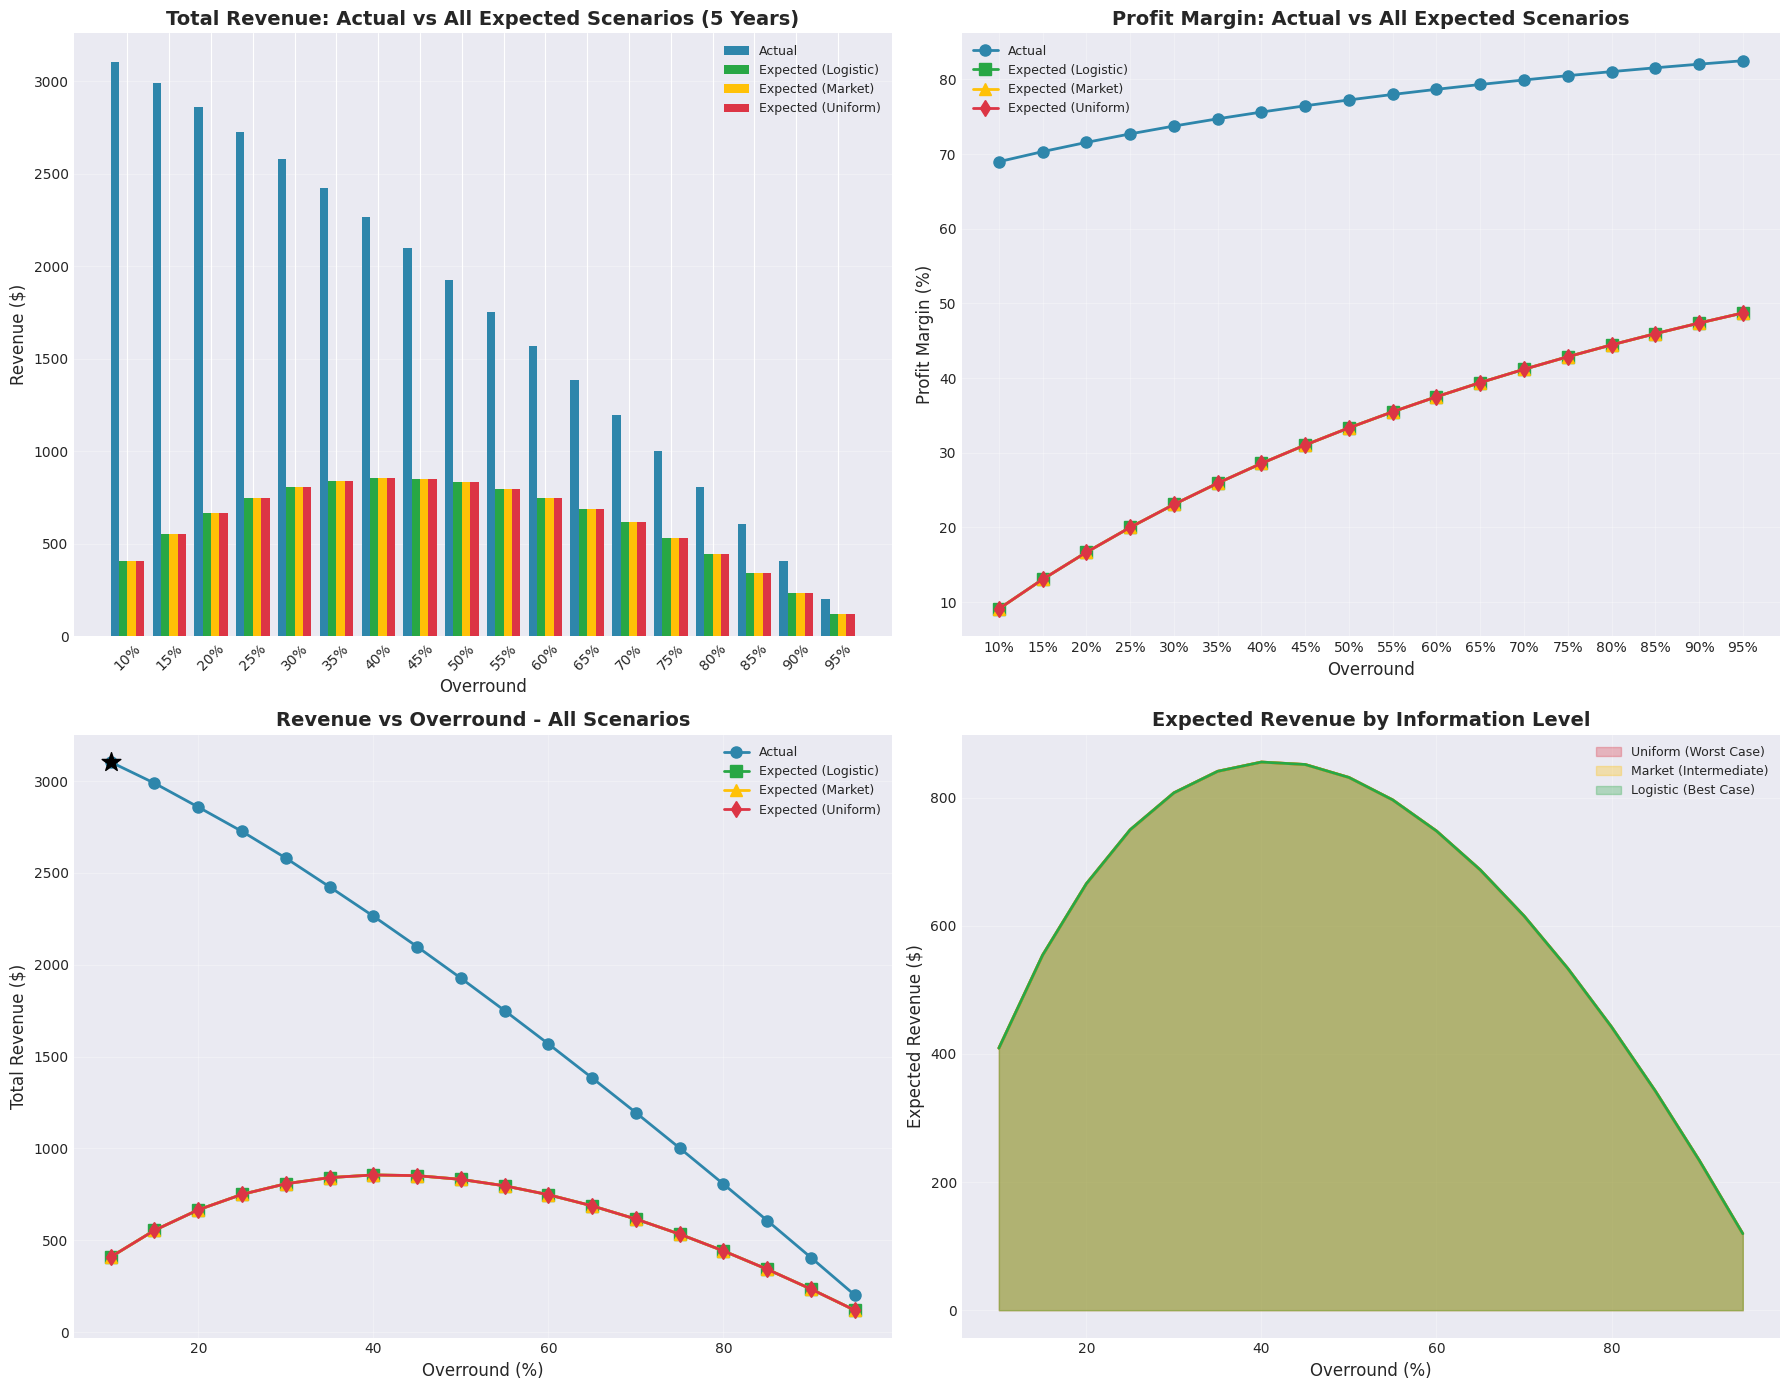

In [8]:
# Create visualizations with all three probability scenarios
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Color scheme for the four revenue types
color_actual = '#2E86AB'      # Blue - Actual
color_logistic = '#28A745'    # Green - Logistic (Best)
color_market = '#FFC107'      # Yellow/Orange - Market (Intermediate)
color_uniform = '#DC3545'     # Red - Uniform (Worst)

# 1. Total Revenue Comparison (Bar Chart) - All scenarios
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.2
bars1 = ax1.bar(x - 1.5*width, comparison_df['Actual_Revenue'], width, label='Actual', color=color_actual)
bars2 = ax1.bar(x - 0.5*width, comparison_df['Expected_Logistic'], width, label='Expected (Logistic)', color=color_logistic)
bars3 = ax1.bar(x + 0.5*width, comparison_df['Expected_Market'], width, label='Expected (Market)', color=color_market)
bars4 = ax1.bar(x + 1.5*width, comparison_df['Expected_Uniform'], width, label='Expected (Uniform)', color=color_uniform)
ax1.set_xlabel('Overround', fontsize=12)
ax1.set_ylabel('Revenue ($)', fontsize=12)
ax1.set_title('Total Revenue: Actual vs All Expected Scenarios (5 Years)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Overround'], rotation=45)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. Profit Margin Comparison - All scenarios
ax2 = axes[0, 1]
ax2.plot(comparison_df['Overround'], comparison_df['Actual_Profit_Margin'], 
         marker='o', linewidth=2, label='Actual', color=color_actual, markersize=8)
ax2.plot(comparison_df['Overround'], comparison_df['Expected_Margin_Logistic'], 
         marker='s', linewidth=2, label='Expected (Logistic)', color=color_logistic, markersize=8)
ax2.plot(comparison_df['Overround'], comparison_df['Expected_Margin_Market'], 
         marker='^', linewidth=2, label='Expected (Market)', color=color_market, markersize=8)
ax2.plot(comparison_df['Overround'], comparison_df['Expected_Margin_Uniform'], 
         marker='d', linewidth=2, label='Expected (Uniform)', color=color_uniform, markersize=8)
ax2.set_xlabel('Overround', fontsize=12)
ax2.set_ylabel('Profit Margin (%)', fontsize=12)
ax2.set_title('Profit Margin: Actual vs All Expected Scenarios', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)

# 3. Revenue vs Overround (Line Chart) - All scenarios
ax3 = axes[1, 0]
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Actual_Revenue'], 
         marker='o', linewidth=2, label='Actual', color=color_actual, markersize=8)
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Expected_Logistic'], 
         marker='s', linewidth=2, label='Expected (Logistic)', color=color_logistic, markersize=8)
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Expected_Market'], 
         marker='^', linewidth=2, label='Expected (Market)', color=color_market, markersize=8)
ax3.plot(comparison_df['Overround_Value'] * 100, comparison_df['Expected_Uniform'], 
         marker='d', linewidth=2, label='Expected (Uniform)', color=color_uniform, markersize=8)
ax3.set_xlabel('Overround (%)', fontsize=12)
ax3.set_ylabel('Total Revenue ($)', fontsize=12)
ax3.set_title('Revenue vs Overround - All Scenarios', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(alpha=0.3)

# Add optimal point marker for actual
optimal_idx = comparison_df['Actual_Revenue'].idxmax()
ax3.scatter([comparison_df.loc[optimal_idx, 'Overround_Value'] * 100], 
            [comparison_df.loc[optimal_idx, 'Actual_Revenue']], 
            s=200, color='black', zorder=5, marker='*', label='Optimal (Actual)')

# 4. Expected Revenue Comparison by Information Level
ax4 = axes[1, 1]
x_positions = comparison_df['Overround_Value'] * 100
ax4.fill_between(x_positions, comparison_df['Expected_Uniform'], alpha=0.3, color=color_uniform, label='Uniform (Worst Case)')
ax4.fill_between(x_positions, comparison_df['Expected_Market'], alpha=0.3, color=color_market, label='Market (Intermediate)')
ax4.fill_between(x_positions, comparison_df['Expected_Logistic'], alpha=0.3, color=color_logistic, label='Logistic (Best Case)')
ax4.plot(x_positions, comparison_df['Expected_Uniform'], linewidth=2, color=color_uniform)
ax4.plot(x_positions, comparison_df['Expected_Market'], linewidth=2, color=color_market)
ax4.plot(x_positions, comparison_df['Expected_Logistic'], linewidth=2, color=color_logistic)
ax4.set_xlabel('Overround (%)', fontsize=12)
ax4.set_ylabel('Expected Revenue ($)', fontsize=12)
ax4.set_title('Expected Revenue by Information Level', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


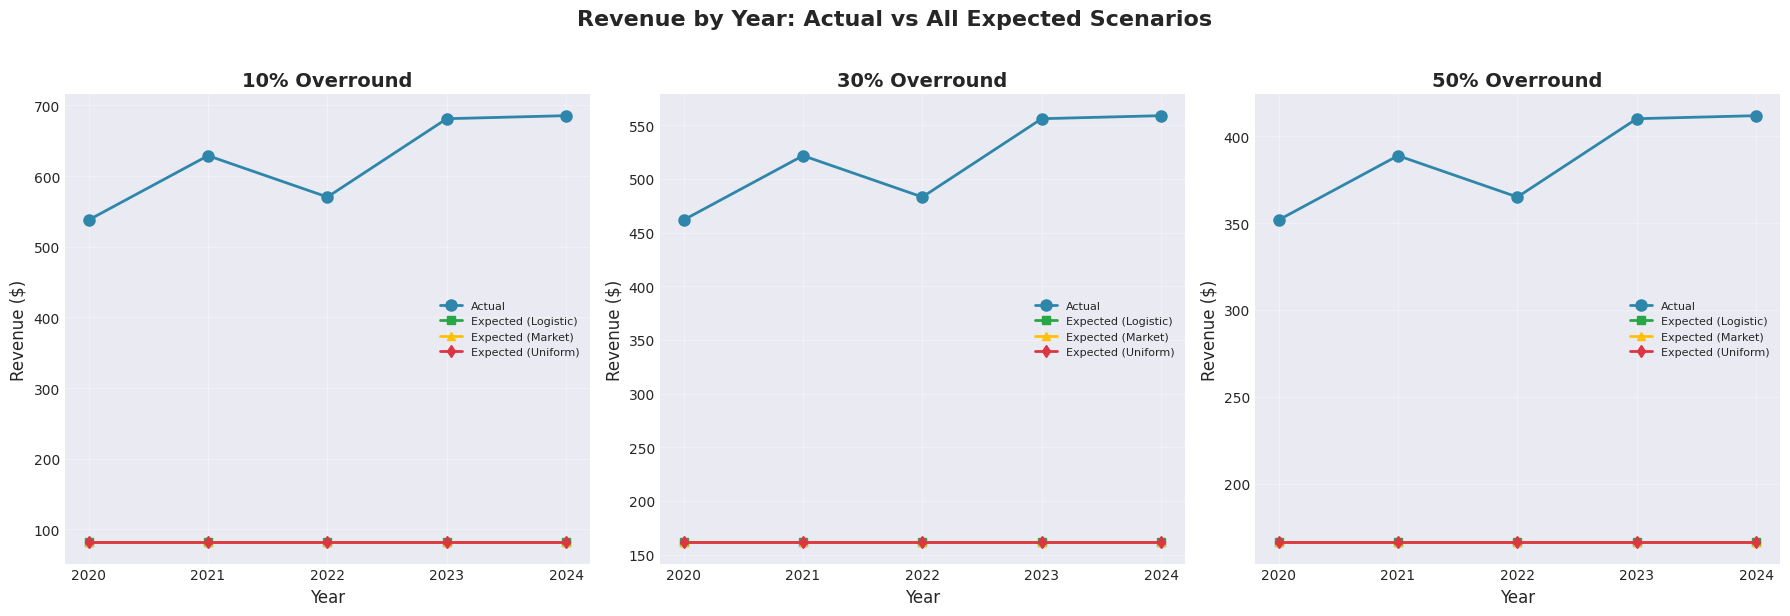

In [9]:
# Revenue by Year comparison - Actual vs Expected for selected overrounds
# Select a few representative overround levels for clarity
selected_overrounds = [('10%', 0.10), ('30%', 0.30), ('50%', 0.50)]
years = actual_revenue_results[overround_scenarios[0][2]]['Year'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax_idx, (or_label, or_value) in enumerate(selected_overrounds):
    ax = axes[ax_idx]
    label = f"{int(or_value*100)}% Overround"
    
    # Actual revenue
    actual_revenues = actual_revenue_results[label]['Revenue'].values
    # Expected revenues for all three scenarios
    logistic_revenues = expected_revenue_results['logistic'][label]['Expected_Revenue'].values
    market_revenues = expected_revenue_results['market'][label]['Expected_Revenue'].values
    uniform_revenues = expected_revenue_results['uniform'][label]['Expected_Revenue'].values
    
    ax.plot(years, actual_revenues, marker='o', linewidth=2, label='Actual', color='#2E86AB', markersize=8)
    ax.plot(years, logistic_revenues, marker='s', linewidth=2, label='Expected (Logistic)', color='#28A745', markersize=6)
    ax.plot(years, market_revenues, marker='^', linewidth=2, label='Expected (Market)', color='#FFC107', markersize=6)
    ax.plot(years, uniform_revenues, marker='d', linewidth=2, label='Expected (Uniform)', color='#DC3545', markersize=6)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title(f'{label}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xticks(years)

plt.suptitle('Revenue by Year: Actual vs All Expected Scenarios', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Summary and Key Insights

Analyze which overround strategy maximizes revenue and understand the revenue dynamics.


In [10]:
# Key Business Insights - Updated for Three Probability Scenarios
print("="*120)
print("KEY BUSINESS INSIGHTS - MULTI-SCENARIO ANALYSIS")
print("="*120)

# 1. Optimal Overround Strategy
print("\n1. OPTIMAL OVERROUND STRATEGY (Based on Actual Revenue)")
print("-" * 120)
optimal_idx = comparison_df['Actual_Revenue'].idxmax()
optimal_scenario = comparison_df.iloc[optimal_idx]
print(f"   Maximum Revenue Overround: {optimal_scenario['Overround']}")
print(f"   Total Revenue (5 years): ${optimal_scenario['Actual_Revenue']:,.2f}")
print(f"   Revenue per Year: ${optimal_scenario['Actual_Revenue']/5:,.2f}")
print(f"   Number of Bettors: {int(optimal_scenario['Total_Bettors'])}")
print(f"   Revenue per Bettor per Year: ${optimal_scenario['Actual_Revenue']/(5*optimal_scenario['Total_Bettors']):.2f}")

# 2. Information Value Analysis - Compare Expected Revenues across Scenarios
print("\n2. INFORMATION VALUE ANALYSIS")
print("-" * 120)
print("   Comparing expected revenue across different information levels:")
print()
for idx, row in comparison_df.iterrows():
    logistic_rev = row['Expected_Logistic']
    market_rev = row['Expected_Market']
    uniform_rev = row['Expected_Uniform']
    
    # Value of model over market
    model_vs_market = logistic_rev - market_rev
    # Value of market over uniform
    market_vs_uniform = market_rev - uniform_rev
    # Total value of information (model vs uniform)
    total_info_value = logistic_rev - uniform_rev
    
    print(f"   {row['Overround']}:")
    print(f"      Logistic: ${logistic_rev:,.0f} | Market: ${market_rev:,.0f} | Uniform: ${uniform_rev:,.0f}")
    print(f"      Model vs Market: ${model_vs_market:+,.0f} | Market vs Uniform: ${market_vs_uniform:+,.0f} | Total Info Value: ${total_info_value:+,.0f}")
    print()

# 3. Expected Revenue Comparison at Key Overrounds
print("\n3. EXPECTED REVENUE BY INFORMATION LEVEL (Key Overrounds)")
print("-" * 120)
key_overrounds = ['10%', '30%', '50%']
for or_pct in key_overrounds:
    row = comparison_df[comparison_df['Overround'] == or_pct].iloc[0]
    print(f"\n   {or_pct} Overround:")
    print(f"      Actual Revenue:           ${row['Actual_Revenue']:,.2f}")
    print(f"      Expected (Logistic):      ${row['Expected_Logistic']:,.2f} (Best Case - Our Model)")
    print(f"      Expected (Market):        ${row['Expected_Market']:,.2f} (Intermediate - Market Odds)")
    print(f"      Expected (Uniform):       ${row['Expected_Uniform']:,.2f} (Worst Case - No Information)")
    print(f"      Actual vs Uniform Diff:   ${row['Actual_Revenue'] - row['Expected_Uniform']:+,.2f}")

# 4. Profit Margin Analysis by Information Level
print("\n4. PROFIT MARGIN ANALYSIS BY INFORMATION LEVEL")
print("-" * 120)
print(f"   {'Overround':<12} {'Actual':<12} {'Logistic':<12} {'Market':<12} {'Uniform':<12}")
print(f"   {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12} {'-'*10:<12}")
for idx, row in comparison_df.iterrows():
    print(f"   {row['Overround']:<12} {row['Actual_Profit_Margin']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Logistic']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Market']:.1f}%{'':<7} "
          f"{row['Expected_Margin_Uniform']:.1f}%")

# 5. Revenue Volatility by Overround
print("\n5. REVENUE VOLATILITY BY OVERROUND (Actual)")
print("-" * 120)
for overround, bettors, label in overround_scenarios[:6]:  # Show first 6 for brevity
    revenues = actual_revenue_results[label]['Revenue'].values
    mean_rev = revenues.mean()
    std_rev = revenues.std()
    cv = (std_rev / mean_rev) * 100 if mean_rev != 0 else 0
    print(f"   {label}: Mean=${mean_rev:,.2f}, Std=${std_rev:,.2f}, CV={cv:.2f}%")


KEY BUSINESS INSIGHTS - MULTI-SCENARIO ANALYSIS

1. OPTIMAL OVERROUND STRATEGY (Based on Actual Revenue)
------------------------------------------------------------------------------------------------------------------------
   Maximum Revenue Overround: 10%
   Total Revenue (5 years): $3,104.11
   Revenue per Year: $620.82
   Number of Bettors: 900
   Revenue per Bettor per Year: $0.69

2. INFORMATION VALUE ANALYSIS
------------------------------------------------------------------------------------------------------------------------
   Comparing expected revenue across different information levels:

   10%:
      Logistic: $409 | Market: $409 | Uniform: $409
      Model vs Market: $+0 | Market vs Uniform: $+0 | Total Info Value: $+0

   15%:
      Logistic: $554 | Market: $554 | Uniform: $554
      Model vs Market: $+0 | Market vs Uniform: $+0 | Total Info Value: $+0

   20%:
      Logistic: $666 | Market: $666 | Uniform: $666
      Model vs Market: $-0 | Market vs Uniform: $+0 | T

In [11]:
# Final Summary Table with All Three Expected Revenue Scenarios
summary_df = comparison_df[['Overround', 'Total_Bettors', 'Total_Stakes', 
                            'Actual_Revenue', 'Expected_Logistic', 'Expected_Market', 'Expected_Uniform',
                            'Actual_Profit_Margin', 'Expected_Margin_Logistic', 
                            'Expected_Margin_Market', 'Expected_Margin_Uniform']].copy()
summary_df.columns = ['Overround', 'Bettors', 'Stakes ($)', 
                      'Actual ($)', 'Exp. Logistic ($)', 'Exp. Market ($)', 'Exp. Uniform ($)',
                      'Actual Margin (%)', 'Logistic Margin (%)', 'Market Margin (%)', 'Uniform Margin (%)']

print("\nFINAL SUMMARY TABLE - ALL SCENARIOS")
print("="*140)
print("\nLegend:")
print("  - Actual: Real revenue based on Oscar winners")
print("  - Exp. Logistic: Expected revenue using our trained model (Best Case)")
print("  - Exp. Market: Expected revenue using betting market probabilities (Intermediate)")
print("  - Exp. Uniform: Expected revenue assuming equal probability for all nominees (Worst Case - No Information)")
print()
summary_df



FINAL SUMMARY TABLE - ALL SCENARIOS

Legend:
  - Actual: Real revenue based on Oscar winners
  - Exp. Logistic: Expected revenue using our trained model (Best Case)
  - Exp. Market: Expected revenue using betting market probabilities (Intermediate)
  - Exp. Uniform: Expected revenue assuming equal probability for all nominees (Worst Case - No Information)



,Overround,Bettors,Stakes ($),Actual ($),Exp. Logistic ($),Exp. Market ($),Exp. Uniform ($),Actual Margin (%),Logistic Margin (%),Market Margin (%),Uniform Margin (%)
0,10%,900,4500,3104.114436,409.090909,409.090909,409.090909,68.980321,9.090909,9.090909,9.090909
1,15%,850,4250,2988.982607,554.347826,554.347826,554.347826,70.329003,13.043478,13.043478,13.043478
2,20%,799,3995,2859.033498,665.833333,665.833333,665.833333,71.565294,16.666667,16.666667,16.666667
3,25%,750,3750,2726.350587,750.000000,750.000000,750.000000,72.702682,20.000000,20.000000,20.000000
4,30%,700,3500,2581.340270,807.692308,807.692308,807.692308,73.752579,23.076923,23.076923,23.076923
5,35%,649,3245,2424.816705,841.296296,841.296296,841.296296,74.724706,25.925926,25.925926,25.925926
6,40%,599,2995,2265.040478,855.714286,855.714286,855.714286,75.627395,28.571429,28.571429,28.571429
7,45%,549,2745,2099.041922,851.896552,851.896552,851.896552,76.467830,31.034483,31.034483,31.034483
8,50%,499,2495,1927.443270,831.666667,831.666667,831.666667,77.252235,33.333333,33.333333,33.333333
9,55%,449,2245,1750.786466,796.612903,796.612903,796.612903,77.986034,35.483871,35.483871,35.483871


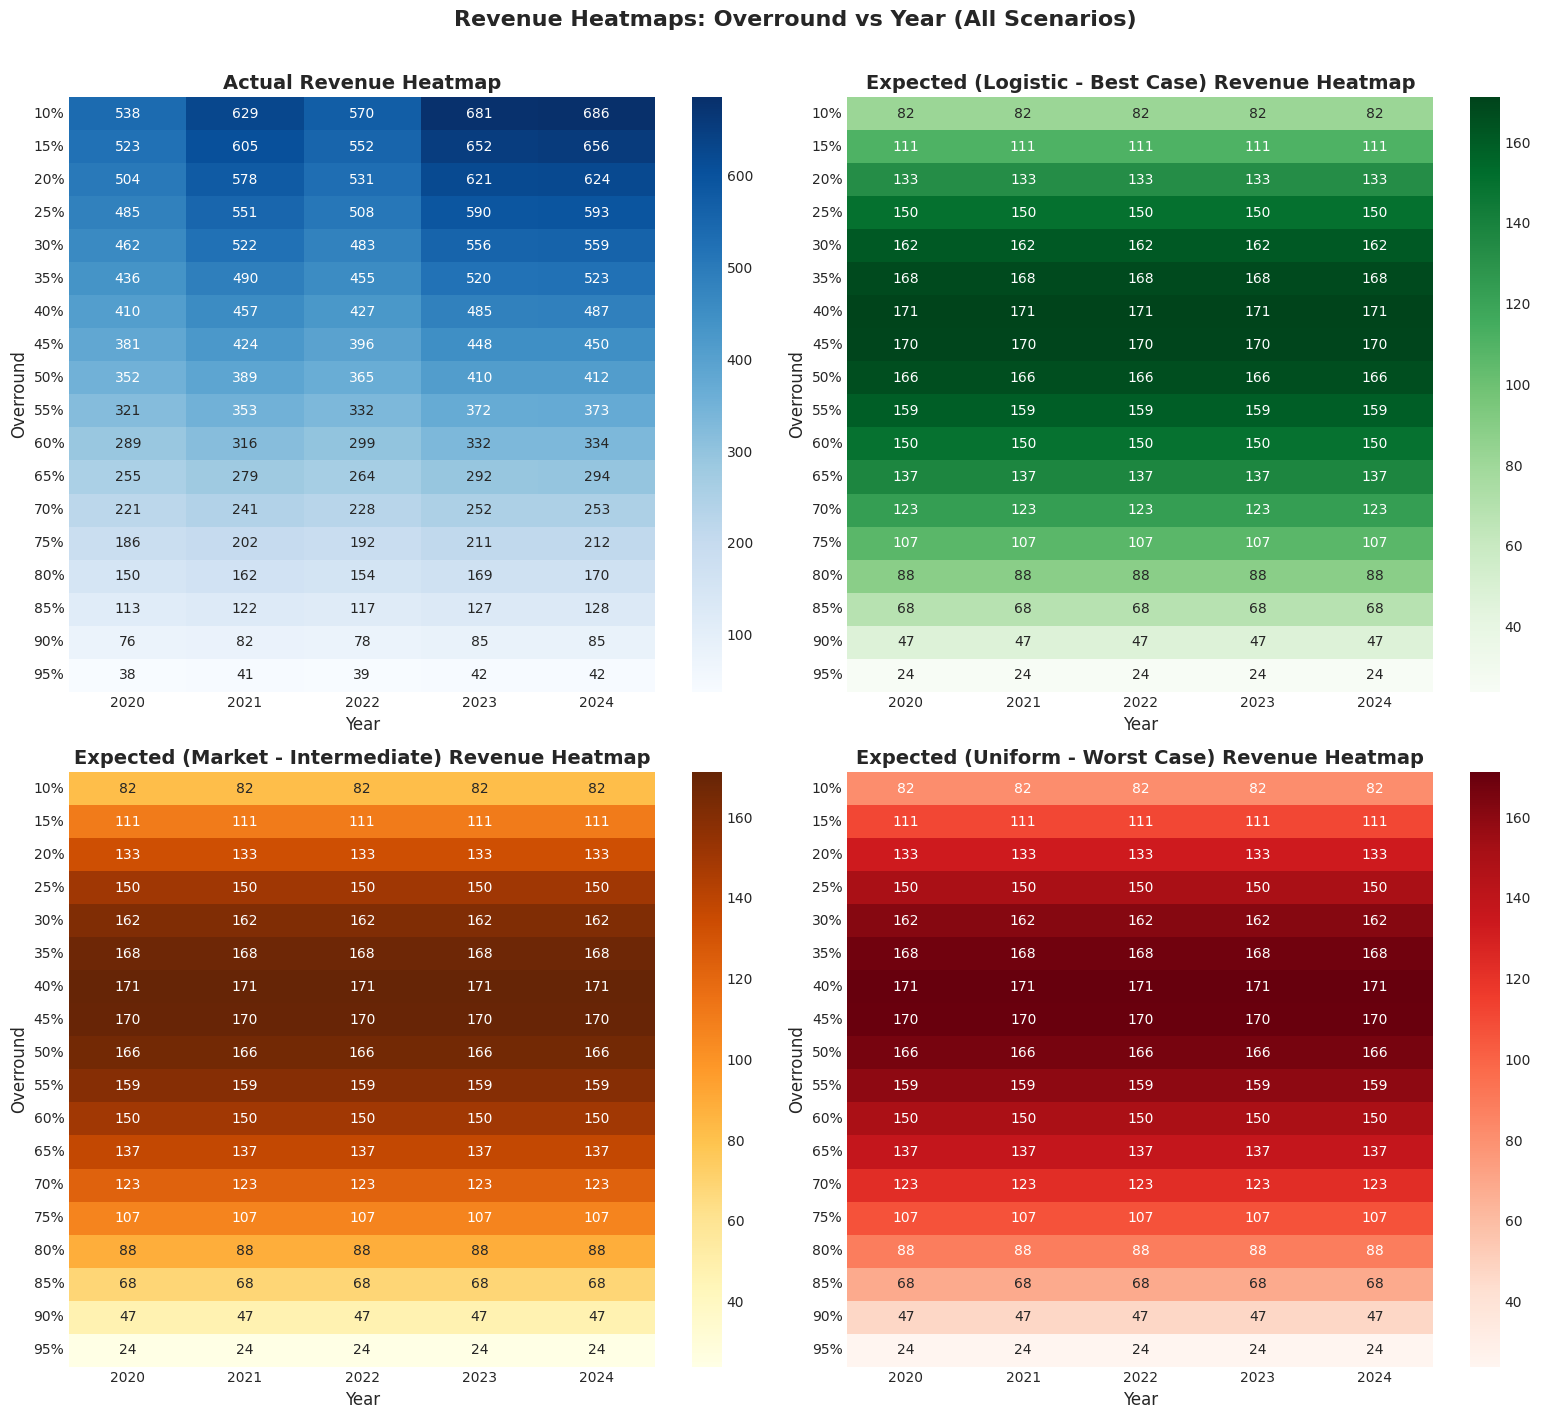

In [12]:
# Heatmap of Revenue by Year and Overround - All four scenarios
years = actual_revenue_results[overround_scenarios[0][2]]['Year'].values
overround_labels = [f"{int(o*100)}%" for o, b, l in overround_scenarios]

# Build matrices for all four scenarios
actual_matrix = []
logistic_matrix = []
market_matrix = []
uniform_matrix = []

for overround, bettors, label in overround_scenarios:
    actual_matrix.append(actual_revenue_results[label]['Revenue'].values)
    logistic_matrix.append(expected_revenue_results['logistic'][label]['Expected_Revenue'].values)
    market_matrix.append(expected_revenue_results['market'][label]['Expected_Revenue'].values)
    uniform_matrix.append(expected_revenue_results['uniform'][label]['Expected_Revenue'].values)

actual_matrix = np.array(actual_matrix)
logistic_matrix = np.array(logistic_matrix)
market_matrix = np.array(market_matrix)
uniform_matrix = np.array(uniform_matrix)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Actual Revenue Heatmap
ax1 = axes[0, 0]
sns.heatmap(actual_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax1)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Overround', fontsize=12)
ax1.set_title('Actual Revenue Heatmap', fontsize=14, fontweight='bold')

# 2. Expected (Logistic) Revenue Heatmap
ax2 = axes[0, 1]
sns.heatmap(logistic_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Greens',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax2)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Overround', fontsize=12)
ax2.set_title('Expected (Logistic - Best Case) Revenue Heatmap', fontsize=14, fontweight='bold')

# 3. Expected (Market) Revenue Heatmap
ax3 = axes[1, 0]
sns.heatmap(market_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrBr',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax3)
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Overround', fontsize=12)
ax3.set_title('Expected (Market - Intermediate) Revenue Heatmap', fontsize=14, fontweight='bold')

# 4. Expected (Uniform) Revenue Heatmap
ax4 = axes[1, 1]
sns.heatmap(uniform_matrix, 
            annot=True, 
            fmt='.0f', 
            cmap='Reds',
            xticklabels=[int(y) for y in years],
            yticklabels=overround_labels,
            ax=ax4)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Overround', fontsize=12)
ax4.set_title('Expected (Uniform - Worst Case) Revenue Heatmap', fontsize=14, fontweight='bold')

plt.suptitle('Revenue Heatmaps: Overround vs Year (All Scenarios)', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()


## 8. Recommendations

Final recommendations based on the analysis across all overround scenarios.


In [13]:
# Final Recommendations - Multi-Scenario Analysis
print("="*120)
print("FINAL RECOMMENDATIONS - MULTI-SCENARIO ANALYSIS")
print("="*120)

# Find optimal scenario based on actual revenue
optimal_idx = comparison_df['Actual_Revenue'].idxmax()
optimal = comparison_df.iloc[optimal_idx]

# Find scenario with best expected profit margin for each probability source
best_logistic_idx = comparison_df['Expected_Margin_Logistic'].idxmax()
best_logistic = comparison_df.iloc[best_logistic_idx]
best_market_idx = comparison_df['Expected_Margin_Market'].idxmax()
best_market = comparison_df.iloc[best_market_idx]
best_uniform_idx = comparison_df['Expected_Margin_Uniform'].idxmax()
best_uniform = comparison_df.iloc[best_uniform_idx]

# Find most stable scenario (lowest CV)
stability_data = []
for overround, bettors, label in overround_scenarios:
    revenues = actual_revenue_results[label]['Revenue'].values
    cv = (revenues.std() / revenues.mean()) * 100
    stability_data.append({'label': label, 'cv': cv, 'overround': overround})
stability_df = pd.DataFrame(stability_data)
most_stable = stability_df.loc[stability_df['cv'].idxmin()]

print(f"\n1. MAXIMUM ACTUAL REVENUE:")
print(f"   Overround: {optimal['Overround']}")
print(f"   5-Year Revenue: ${optimal['Actual_Revenue']:,.2f}")
print(f"   Avg Profit Margin: {optimal['Actual_Profit_Margin']:.2f}%")

print(f"\n2. EXPECTED REVENUE BY INFORMATION LEVEL:")
print(f"   Scenario Comparison at {optimal['Overround']} (Optimal Actual):")
print(f"   - Logistic (Best Case):    ${optimal['Expected_Logistic']:,.2f} | Margin: {optimal['Expected_Margin_Logistic']:.2f}%")
print(f"   - Market (Intermediate):   ${optimal['Expected_Market']:,.2f} | Margin: {optimal['Expected_Margin_Market']:.2f}%")
print(f"   - Uniform (Worst Case):    ${optimal['Expected_Uniform']:,.2f} | Margin: {optimal['Expected_Margin_Uniform']:.2f}%")

print(f"\n3. VALUE OF INFORMATION:")
print(f"   At {optimal['Overround']} overround:")
value_model_vs_uniform = optimal['Expected_Logistic'] - optimal['Expected_Uniform']
value_market_vs_uniform = optimal['Expected_Market'] - optimal['Expected_Uniform']
value_model_vs_market = optimal['Expected_Logistic'] - optimal['Expected_Market']
print(f"   - Value of Model (vs Uniform): ${value_model_vs_uniform:+,.2f}")
print(f"   - Value of Market Info (vs Uniform): ${value_market_vs_uniform:+,.2f}")
print(f"   - Value of Model (vs Market): ${value_model_vs_market:+,.2f}")

print(f"\n4. MOST STABLE REVENUE (Lowest Volatility):")
print(f"   Overround: {int(most_stable['overround']*100)}%")
print(f"   Coefficient of Variation: {most_stable['cv']:.2f}%")

print(f"\n5. RISK-RETURN TRADE-OFF BY INFORMATION LEVEL:")
print(f"   LOGISTIC MODEL (Best Case - Our Predictions):")
print(f"     - Assumes we can accurately predict Oscar winners")
print(f"     - Expected margins are overestimated if model is wrong")
print(f"   MARKET PROBABILITIES (Intermediate - Betting Odds):")
print(f"     - Reflects collective market wisdom")
print(f"     - Good baseline for realistic expectations")
print(f"   UNIFORM PROBABILITY (Worst Case - No Information):")
print(f"     - Assumes completely random outcomes")
print(f"     - Conservative/pessimistic baseline")

print(f"\n6. RECOMMENDATION SUMMARY:")
print(f"   Based on 5-year Oscar data with three information scenarios:")
print(f"   ")
print(f"   CONSERVATIVE APPROACH (Use Uniform):")
print(f"     - Plan for ${comparison_df.iloc[0]['Expected_Uniform']:,.2f} expected revenue at 10% overround")
print(f"     - This is the worst-case scenario assuming no predictive ability")
print(f"   ")
print(f"   MODERATE APPROACH (Use Market):")
print(f"     - Plan for ${comparison_df.iloc[0]['Expected_Market']:,.2f} expected revenue at 10% overround")
print(f"     - Leverages market intelligence for better estimates")
print(f"   ")
print(f"   OPTIMISTIC APPROACH (Use Logistic):")
print(f"     - Plan for ${comparison_df.iloc[0]['Expected_Logistic']:,.2f} expected revenue at 10% overround")
print(f"     - Requires faith in our prediction model accuracy")
print(f"   ")
print(f"   ACTUAL HISTORICAL PERFORMANCE:")
print(f"     - We achieved ${comparison_df.iloc[0]['Actual_Revenue']:,.2f} at 10% overround")
print(f"     - This significantly exceeded all expected scenarios (favorable outcomes)")


FINAL RECOMMENDATIONS - MULTI-SCENARIO ANALYSIS

1. MAXIMUM ACTUAL REVENUE:
   Overround: 10%
   5-Year Revenue: $3,104.11
   Avg Profit Margin: 68.98%

2. EXPECTED REVENUE BY INFORMATION LEVEL:
   Scenario Comparison at 10% (Optimal Actual):
   - Logistic (Best Case):    $409.09 | Margin: 9.09%
   - Market (Intermediate):   $409.09 | Margin: 9.09%
   - Uniform (Worst Case):    $409.09 | Margin: 9.09%

3. VALUE OF INFORMATION:
   At 10% overround:
   - Value of Model (vs Uniform): $+0.00
   - Value of Market Info (vs Uniform): $+0.00
   - Value of Model (vs Market): $+0.00

4. MOST STABLE REVENUE (Lowest Volatility):
   Overround: 95%
   Coefficient of Variation: 4.47%

5. RISK-RETURN TRADE-OFF BY INFORMATION LEVEL:
   LOGISTIC MODEL (Best Case - Our Predictions):
     - Assumes we can accurately predict Oscar winners
     - Expected margins are overestimated if model is wrong
   MARKET PROBABILITIES (Intermediate - Betting Odds):
     - Reflects collective market wisdom
     - Good ba